# Imports

In [3]:
import pandas as pd
from pathlib import Path
import os
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Obtenção dos dados

In [4]:
# Listar arquivos no diretório acima
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Pre-processamento'

file_path_raw = base_path / 'dataset_cotton_fruit.xlsx'
file_path_msc = base_path / 'data_msc.xlsx'
file_path_snv = base_path / 'data_snv.xlsx'
file_path_sg = base_path / 'data_savgol_ordem_1.xlsx'

df_raw = pd.read_excel(file_path_raw)
df_msc = pd.read_excel(file_path_msc)
df_snv = pd.read_excel(file_path_snv)
df_sg = pd.read_excel(file_path_sg)


# PLSR

In [5]:
X = df_raw.drop(df_raw.columns[0:6], axis=1).values
y_sst = df_raw['SST'].values
y_ph = df_raw['PH'].values
y_at = df_raw['AT'].values
y_firmeza = df_raw['FIRMEZA (N)'].values
y_ubs = df_raw['UBS (%)'].values

In [6]:
def optimise_pls(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    
    # Mean centering
    X_mean = np.mean(X, axis=0)
    X -= X_mean

    mse = []
    component = np.arange(1, n_comp + 1)

    for i in component:
        pls = PLSRegression(n_components=i)

        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)

        mse.append(mean_squared_error(y, y_cv))

        comp = 100*(i)/n_comp
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")

    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin)
    stdout.write("\n")

    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color='blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)

        plt.show()

    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin)

    # Fit to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)

    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    # Calculate root mean squared error for calibration and cross validation
    rmse_c = np.sqrt(mse_c)
    rmse_cv = np.sqrt(mse_cv)

    # Calculate bias for calibration and cross validation
    bias_c = np.mean(y - y_c)
    bias_cv = np.mean(y - y_cv)

    # Calculate RPD for cross validation
    rpd_cv = np.std(y) / rmse_cv

    print('R2 calib: %5.6f' % score_c)
    print('R2 CV: %5.6f' % score_cv)
    print('RMSE calib: %5.6f' % rmse_c)
    print('RMSE CV: %5.6f' % rmse_cv)
    print('Bias calib: %5.6f' % bias_c)
    print('Bias CV: %5.6f' % bias_cv)
    print('RPD CV: %5.6f' % rpd_cv)

    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)

    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='green', edgecolors='k')
        # Plot the best fit line
        ax.plot(np.polyval(z, y), y, c='blue', linewidth=1)
        # Plot the ideal 1:1 line
        ax.plot(y, y, color='red', linewidth=1)
        plt.title('$R^{2}$ (CV): ' + str(score_cv))
        plt.xlabel('Predicted')
        plt.ylabel('Reference')

        plt.show()

    return

# Exemplo de uso
# optimize_pls_cv(X, y, n_comp=10, plot_components=True)


# Dados brutos

100% completed
Suggested number of components:  8



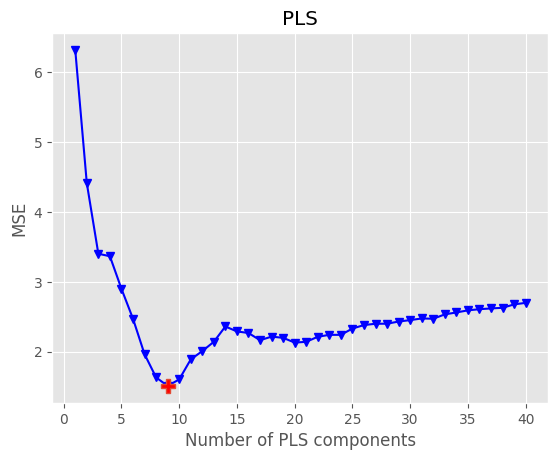

R2 calib: 0.819351
R2 CV: 0.739803
RMSE calib: 1.064104
RMSE CV: 1.277077
Bias calib: -0.000000
Bias CV: -0.046996
RPD CV: 1.960420


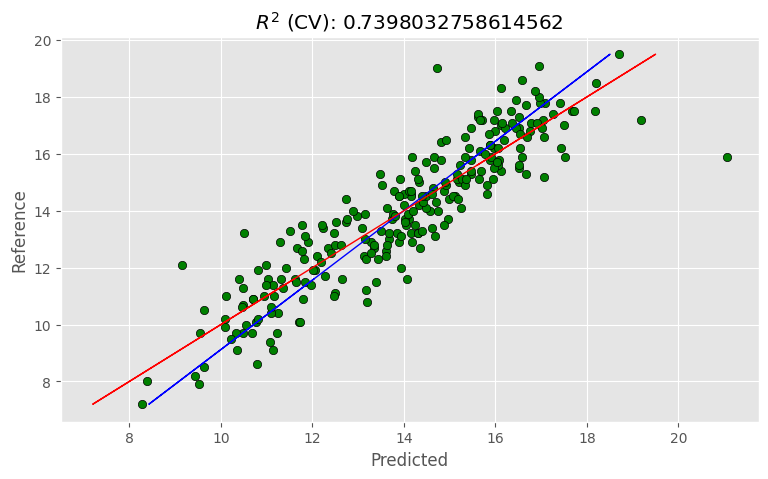

In [7]:
optimise_pls(X,y_sst,40,True)

100% completed
Suggested number of components:  16



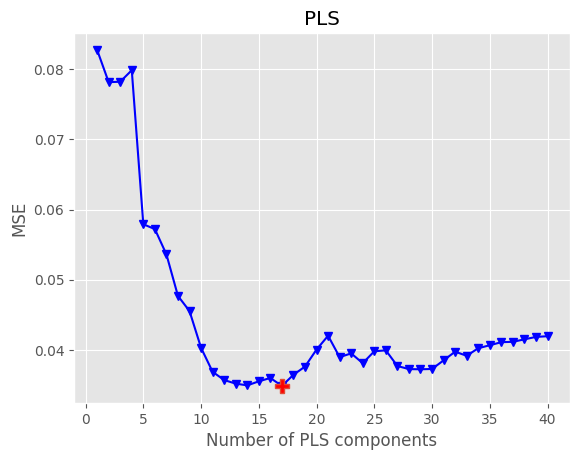

R2 calib: 0.813260
R2 CV: 0.498972
RMSE calib: 0.115808
RMSE CV: 0.189693
Bias calib: 0.000000
Bias CV: 0.006474
RPD CV: 1.412762


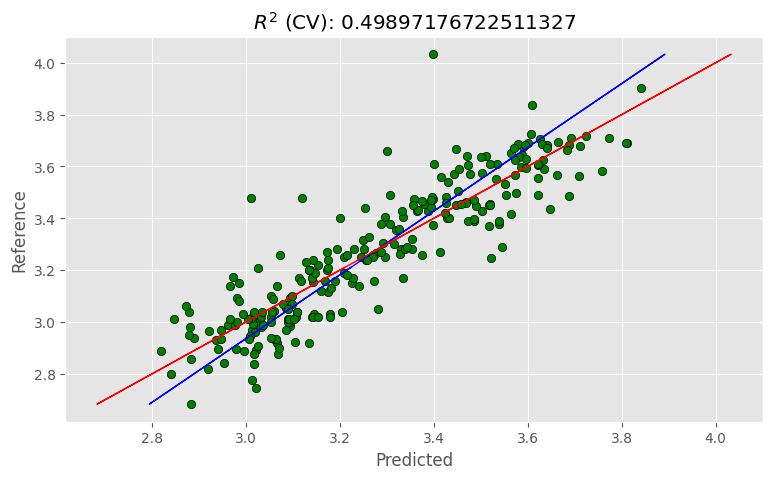

In [8]:
optimise_pls(X,y_ph,40,True)

100% completed
Suggested number of components:  16



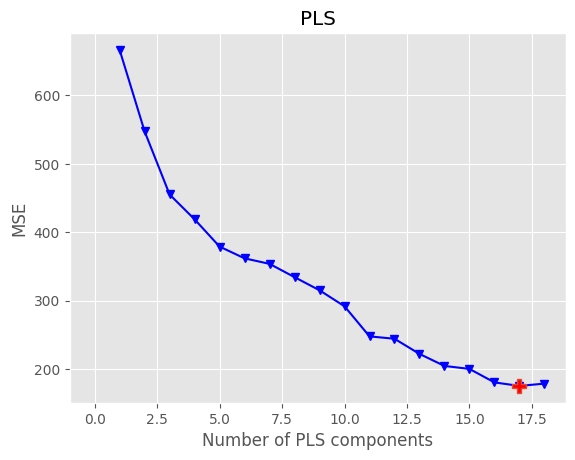

R2 calib: 0.911372
R2 CV: 0.684925
RMSE calib: 7.127673
RMSE CV: 13.439105
Bias calib: 0.000000
Bias CV: -0.786492
RPD CV: 1.781529


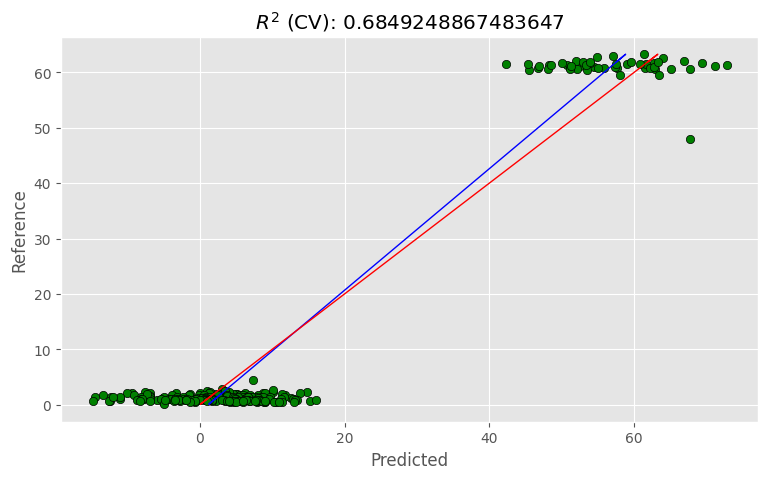

In [9]:
optimise_pls(X,y_at,18,True)

# MSC

In [10]:
X = df_msc

100% completed
Suggested number of components:  13



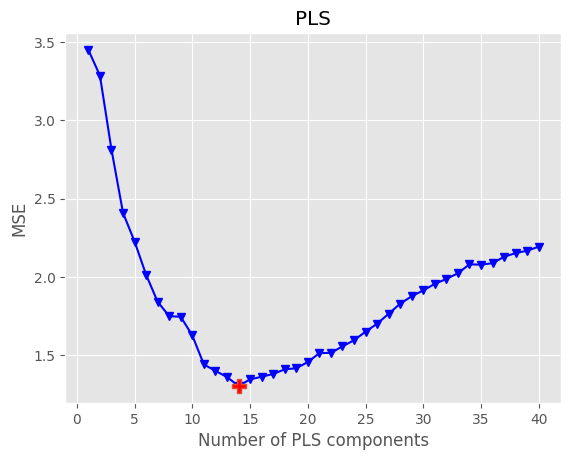

R2 calib: 0.893498
R2 CV: 0.782786
RMSE calib: 0.817043
RMSE CV: 1.166837
Bias calib: -0.000000
Bias CV: -0.030168
RPD CV: 2.145636


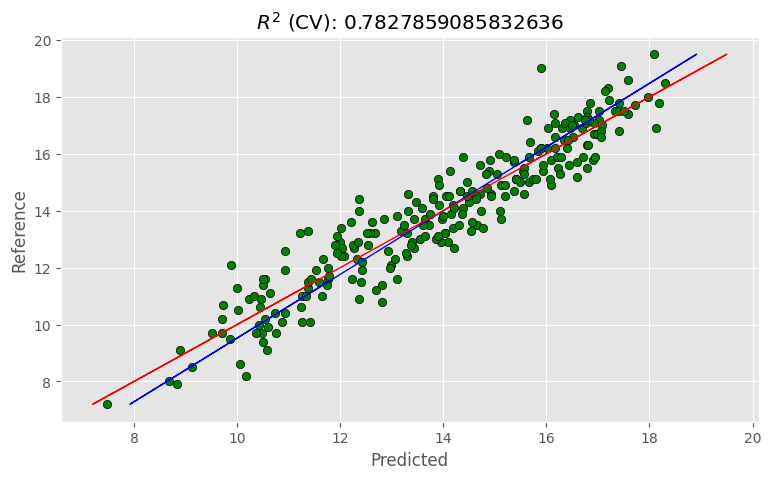

In [11]:
optimise_pls(X,y_sst,40,True)

100% completed
Suggested number of components:  12



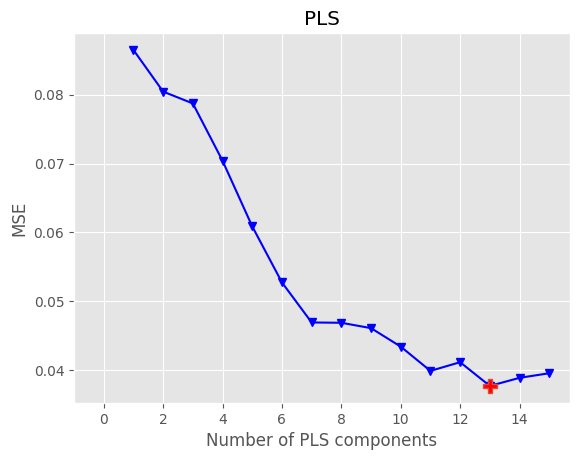

R2 calib: 0.722922
R2 CV: 0.427384
RMSE calib: 0.141065
RMSE CV: 0.202792
Bias calib: 0.000000
Bias CV: 0.005128
RPD CV: 1.321503


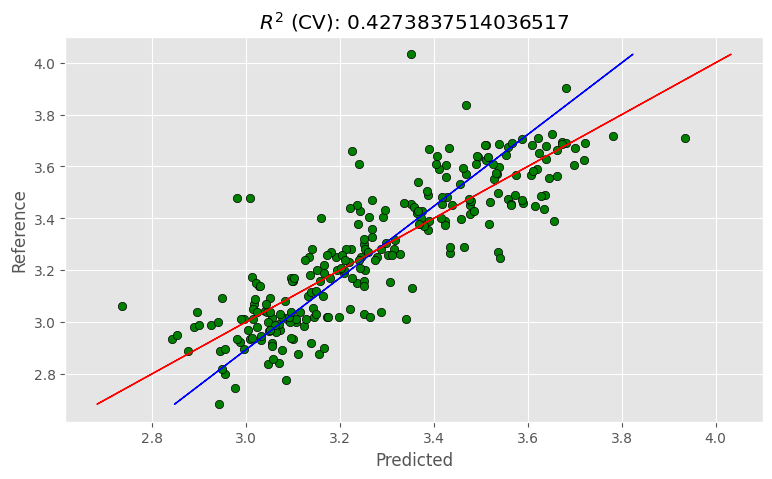

In [13]:
optimise_pls(X,y_ph,15,True)

100% completed
Suggested number of components:  20



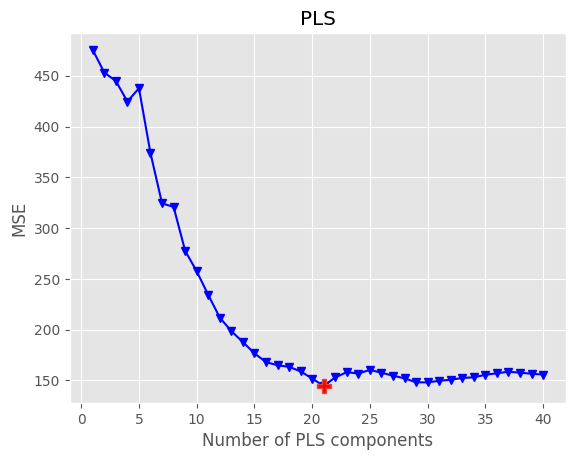

R2 calib: 0.963600
R2 CV: 0.735178
RMSE calib: 4.567846
RMSE CV: 12.320846
Bias calib: -0.000000
Bias CV: -0.155648
RPD CV: 1.943223


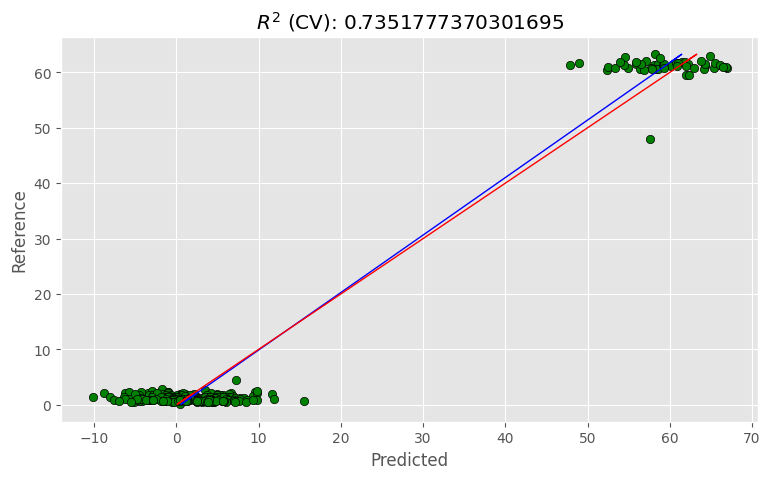

In [15]:
optimise_pls(X,y_at,40,True)